# Project: Road Accidents in France based on Annual Road Traffic Accident Injury Database (2005 - 2023)

## Step 1: Exploration + Data Visualization

## Further Data Exploration

This notebook focuses on exploratory data analysis to better understand the dataset, detect outliers, and visualize key patterns that influence accident severity.

---

First, import the clean and reviewd data file from the previous notebook 1.0-julia-exploration.ipynbn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set styles
sns.set_style("white")
sns.set_context("paper")
sns.set_palette("colorblind")
sns.despine(trim=True)
plt.rcParams["figure.figsize"] = (6, 4)

<Figure size 640x480 with 0 Axes>

In [2]:
file_path = "../data/processed/accidents_processed.csv"
df = pd.read_csv(file_path, low_memory=False)

### 1. Outlier Detection

Outlier detection was performed across multiple dimensions to improve data quality and ensure model reliability.

#### a. Numerical Outliers

Univariate analysis was conducted on numerical features using boxplots and the IQR (interquartile range) method.

Key variables analyzed:
- `hour` (time of accident). Range: 0–23, all within valid hours. Conclusion: No outliers detected.
- `an_nais` (year of birth → age). Age range: 0–120, age > 100: unusual, but could be valid, keep as it is.
- `nbv` (number of road lanes). 0 and -1 (not specified?) values, also many outliers where the number of lanes is >10, highly unlikely, typo or placeholder. Replaced values **less than 1** and **greater than 10** with `NaN`
- `larrout` (width of the carriageway). 0 and -1 (not specified?) values. Replaced values **less than 1** with `NaN`. These values are not physically meaningful and likely indicate missing data. **Due to high number of NaN and outliers > 200m (typo?) this variable might be removed for the future analysis**

In [4]:
df["age"] = df["an"] - df["an_nais"]
df["larrout_numeric"] = pd.to_numeric(df["larrout"], errors="coerce")
df["nbv"] = pd.to_numeric(df["nbv"], errors="coerce").astype("Int64")

# Variables to analyze
variables = ["hour", "age", "nbv", "larrout_numeric"]

# Statistical summaries
summary_stats = df[variables].describe().T
print(summary_stats)

                     count       mean        std   min   25%   50%   75%  \
hour             7543225.0  13.728557   5.261401   0.0  10.0  15.0  18.0   
age              7520180.0  37.687057  17.813839   0.0  24.0  35.0  50.0   
nbv              7523827.0   2.280211   1.663498  -1.0   2.0   2.0   3.0   
larrout_numeric  6918143.0  52.980793  67.130575 -81.0   0.0  54.0  80.0   

                   max  
hour              23.0  
age              120.0  
nbv               99.0  
larrout_numeric  999.0  


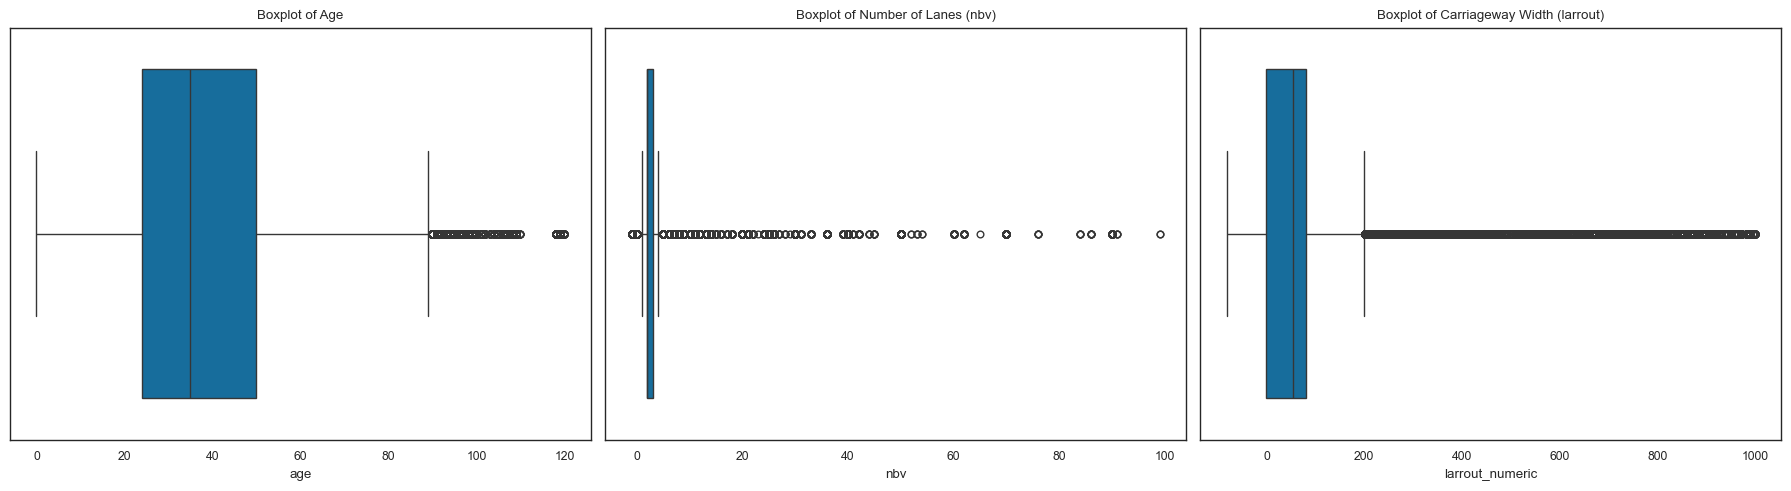

In [5]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df["age"])
plt.title("Boxplot of Age")

plt.subplot(1, 3, 2)
sns.boxplot(x=df["nbv"])
plt.title("Boxplot of Number of Lanes (nbv)")

plt.subplot(1, 3, 3)
sns.boxplot(x=df["larrout_numeric"])
plt.title("Boxplot of Carriageway Width (larrout)")

plt.tight_layout()
plt.show()

an_nais (Age) and Hour variables look ok, focus on nbv and larrout outliers

In [9]:
# IQR method for nbv
q1_nbv = df["nbv"].quantile(0.25)
q3_nbv = df["nbv"].quantile(0.75)
iqr_nbv = q3_nbv - q1_nbv
nbv_outliers = df[(df["nbv"] < (q1_nbv - 1.5 * iqr_nbv)) | (df["nbv"] > (q3_nbv + 1.5 * iqr_nbv))]

# IQR method for larrout
q1_lar = df["larrout_numeric"].quantile(0.25)
q3_lar = df["larrout_numeric"].quantile(0.75)
iqr_lar = q3_lar - q1_lar
larrout_outliers = df[(df["larrout_numeric"] < (q1_lar - 1.5 * iqr_lar)) | (df["larrout_numeric"] > (q3_lar + 1.5 * iqr_lar))]

#summary
print("nbv lower bound:", q1_nbv - 1.5 * iqr_nbv)
print("nbv upper bound:", q3_nbv + 1.5 * iqr_nbv)
print("larrout lower bound:", q1_lar - 1.5 * iqr_lar)
print("larrout upper bound:", q3_lar + 1.5 * iqr_lar)
print("nbv outliers:", nbv_outliers.shape[0])
print("larrout outliers:", larrout_outliers.shape[0])

nbv lower bound: 0.5
nbv upper bound: 4.5
larrout lower bound: -120.0
larrout upper bound: 200.0
nbv outliers: 1009732
larrout outliers: 152439


Cleaning `nbv` and `larrout` Variables

In [12]:
# Make a copy of the original DataFrame
df_cleaned = df.copy()

# Set invalid values to NaN
df_cleaned.loc[(df_cleaned["nbv"] < 1) | (df_cleaned["nbv"] > 10), "nbv"] = pd.NA
df_cleaned.loc[df["larrout_numeric"] < 1, "larrout_numeric"] = pd.NA

#### b. Spatial Outliers (GPS): GPS–INSEE Mismatch Correction

To ensure consistency between geographic coordinates and administrative location data, we validated the `gps_combined_final` column (parsed into `lat_clean` and `long_clean`) against the corresponding `insee_code` (French administrative region identifier).

#### Logic:
- **Mainland INSEE codes** (e.g., 01–95, 2A, 2B) should fall within approximate mainland France GPS bounds:
  - Latitude: 41°N to 52°N
  - Longitude: −5°E to 10°E
- **Overseas INSEE codes** (prefixes starting with `97` or `98`) are expected to fall **outside** these mainland bounds.

#### Action Taken:
- Coordinates with a mismatch between `insee_code` and geographic location were deemed unreliable.
- These mismatched `lat_clean` and `long_clean` values were replaced with `NaN`.

In [17]:
# Split GPS column into latitude and longitude
df_cleaned[["lat_clean", "long_clean"]] = df_cleaned["gps_combined_final"].str.split(",", expand=True).astype(float)

# Define INSEE code prefixes
df_cleaned["insee_code"] = df_cleaned["insee_code"].astype(str)
df_cleaned["insee_prefix"] = df_cleaned["insee_code"].str[:2]

mainland_prefixes = [str(i).zfill(2) for i in range(1, 96)] + ["2A", "2B"]
overseas_prefixes = ["97", "98"]

# Initialize mismatch flag
df_cleaned["gps_insee_mismatch"] = False

# Mismatch: mainland INSEE with GPS outside mainland bounds
df_cleaned.loc[
    (df_cleaned["insee_prefix"].isin(mainland_prefixes)) &
    (~df_cleaned["lat_clean"].between(41, 52) | ~df_cleaned["long_clean"].between(-5, 10)),
    "gps_insee_mismatch"
] = True

# Mismatch: overseas INSEE with GPS inside mainland bounds
df_cleaned.loc[
    (df_cleaned["insee_prefix"].isin(overseas_prefixes)) &
    (df_cleaned["lat_clean"].between(41, 52) & df_cleaned["long_clean"].between(-5, 10)),
    "gps_insee_mismatch"
] = True

# Count of mismatches
total_rows = len(df_cleaned)
mismatch_count = df_cleaned["gps_insee_mismatch"].sum()
mismatch_percent = round((mismatch_count / total_rows) * 100, 2)

# Display summary
print(f"Total rows: {total_rows}")
print(f"GPS–INSEE mismatches: {mismatch_count}")
print(f"Percentage of mismatches: {mismatch_percent}%")

# replace GPS–INSEE mismatches with NaN
df_cleaned.loc[df_cleaned["gps_insee_mismatch"], ["lat_clean", "long_clean"]] = pd.NA

Total rows: 7543225
GPS–INSEE mismatches: 830084
Percentage of mismatches: 11.0%


#### c. Categorical Variable Cleaning: Validation Against Official Codebooks

Each categorical variable was restricted to a predefined set of valid codes based on the national accident reporting schema (e.g., lighting conditions, collision type, vehicle category). Any value outside the accepted range was considered invalid and **replaced with `NaN`**. All instances of `-1` were treated as **missing** and replaced with `NaN`.

In [19]:
categorical_cleaning_rules = {
    "lum": [1, 2, 3, 4, 5],
    "agg": [1, 2],
    "int": list(range(1, 10)),
    "atm": list(range(1, 10)),
    "col": list(range(1, 8)),
    "catr": [1, 2, 3, 4, 5, 6, 7, 9],
    "circ": [1, 2, 3, 4],
    "vosp": [0, 1, 2, 3],
    "prof": [1, 2, 3, 4],
    "plan": [1, 2, 3, 4],
    "surf": list(range(1, 10)),
    "infra": list(range(0, 10)),
    "situ": [0, 1, 2, 3, 4, 5, 6, 8],
    "senc": [0, 1, 2, 3],
    "obs": list(range(0, 10)),
    "obsm": list(range(0, 5)),
    "choc": list(range(0, 9)),
    "manv": list(range(1, 14)),
    "place": list(range(1, 11)),
    "catu": [1, 2, 3],
    "grav": [1, 2, 3, 4],
    "sexe": [1, 2],
    "trajet": [1, 2, 3, 4, 5, 9],
    "locp": list(range(1, 8)),
    "actp": list(range(1, 10)),
    "etatp": [1, 2, 3],
    "catv": [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
        13, 14, 15, 16, 17, 18, 19, 20, 21,
        30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43,
        50, 60, 80, 99
    ],
    "belt_status": [0, 1],
    "helmet_status": [0, 1],
    "child_device_status": [0, 1],
    "reflective_vest_status": [0, 1]
}

# Apply cleaning: invalid codes → NaN, and convert -1 to NaN explicitly before
for col, valid_values in categorical_cleaning_rules.items():
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors="coerce")
        df_cleaned.loc[df_cleaned[col] == -1, col] = pd.NA  # Treat -1 as missing
        df_cleaned.loc[~df_cleaned[col].isin(valid_values), col] = pd.NA


In [21]:
# Store results
outlier_counts = {}

for col, valid_values in categorical_cleaning_rules.items():
    if col in df_cleaned.columns:
        # Count before cleaning
        original_col = pd.to_numeric(df_cleaned[col], errors="coerce")
        invalid_mask = ~original_col.isin(valid_values)
        outlier_count = invalid_mask.sum()
        outlier_counts[col] = outlier_count

# Display results
for col, count in outlier_counts.items():
    print(f"{col}: {count} invalid values replaced with NaN")

lum: 17 invalid values replaced with NaN
agg: 0 invalid values replaced with NaN
int: 618 invalid values replaced with NaN
atm: 333 invalid values replaced with NaN
col: 8770 invalid values replaced with NaN
catr: 2 invalid values replaced with NaN
circ: 348474 invalid values replaced with NaN
vosp: 38717 invalid values replaced with NaN
prof: 397618 invalid values replaced with NaN
plan: 384642 invalid values replaced with NaN
surf: 185389 invalid values replaced with NaN
infra: 41977 invalid values replaced with NaN
situ: 29752 invalid values replaced with NaN
senc: 4232 invalid values replaced with NaN
obs: 241578 invalid values replaced with NaN
obsm: 111379 invalid values replaced with NaN
choc: 109098 invalid values replaced with NaN
manv: 2396579 invalid values replaced with NaN
place: 310879 invalid values replaced with NaN
catu: 5786 invalid values replaced with NaN
grav: 856 invalid values replaced with NaN
sexe: 16614 invalid values replaced with NaN
trajet: 2241419 invalid 

As grav is our target variable, the dataset should only include records with valid injury severity classifications

In [23]:
# Drop rows with missing 'grav'
df_cleaned = df_cleaned.dropna(subset=["grav"])

#### d. Final Column Removal Summary

To optimize the dataset for analysis and modeling, the following columns were dropped based on a combination of high missing values, redundancy, and lack of relevance:

#### High Missingness or Low Informational Value
- `locp`, `actp`, `etatp`: Pedestrian-specific and >95% missing
- `reflective_vest_status`, `child_device_status`, `helmet_status`: Underreported, mostly missing

#### Redundancy or Formatting Issues
- `voie`: Mixed text/numeric street identifiers; replaced by GPS
- `larrout`: Dropped after filtering and standardizing
- `gps_combined_final`: Superseded by cleaned latitude/longitude
- `an_nais`: Used to derive `age`
- `insee_prefix`: Covered by `insee_code`
- `weekday_name`, `hrmn`: Derived from `datetime`
- `num_veh`: Linking key not used in modeling
- `gps_insee_mismatch`: Temporary indicator used for cleaning

#### Replaced by Unified Time Feature
- `an`, `mois`, `jour`: All temporal details now handled by the `datetime` column and its derivatives

In [28]:
# missing values summary
def count_missing_all_forms_with_percent(series):
    total = len(series)
    missing = (
        series.isna().sum() + 
        series.apply(lambda x: isinstance(x, str) and x.strip() == "").sum()
    )
    percent = (missing / total * 100) if total > 0 else 0
    return missing, round(percent, 2)

# Apply to all columns in df_cleaned
missing_data = {
    "column": [],
    "missing_count": [],
    "missing_percent": []
}

for col in df_cleaned.columns:
    count, percent = count_missing_all_forms_with_percent(df_cleaned[col])
    missing_data["column"].append(col)
    missing_data["missing_count"].append(count)
    missing_data["missing_percent"].append(percent)

# Create and display the summary DataFrame
missing_summary = pd.DataFrame(missing_data).sort_values(by="missing_percent", ascending=False).reset_index(drop=True)
print(missing_summary)

                    column  missing_count  missing_percent
0                     locp        7226884            95.82
1                     actp        7206172            95.54
2                    etatp        7206275            95.54
3   reflective_vest_status        6344446            84.12
4      child_device_status        6308869            83.65
5            helmet_status        5175845            68.62
6          larrout_numeric        3372409            44.71
7              belt_status        2550993            33.82
8                     manv        2396150            31.77
9                   trajet        2240564            29.71
10              long_clean         939658            12.46
11               lat_clean         939658            12.46
12                     nbv         675304             8.95
13                    voie         618723             8.20
14                 larrout         591480             7.84
15                    prof         397607             5.

In [30]:
# Final list of all columns to remove
columns_to_drop = [
    # High missingness or low utility
    "locp", "actp", "etatp",
    "reflective_vest_status", "child_device_status", "helmet_status",
    "larrout_numeric",

    # Redundant, mixed-format, or already transformed
    "voie", "larrout", "gps_combined_final", "an_nais",
    "insee_prefix", "weekday_name", "num_veh", "hrmn",
    "gps_insee_mismatch",

    # Time features now covered by `datetime`
    "an", "mois", "jour"
]

# Drop columns from cleaned DataFrame
df_cleaned = df_cleaned.drop(columns=columns_to_drop, errors="ignore")


In [36]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7542369 entries, 0 to 7543224
Data columns (total 35 columns):
 #   Column       Dtype  
---  ------       -----  
 0   num_acc      int64  
 1   lum          float64
 2   agg          float64
 3   int          float64
 4   atm          float64
 5   col          float64
 6   catr         float64
 7   circ         float64
 8   nbv          Int64  
 9   vosp         float64
 10  prof         float64
 11  plan         float64
 12  surf         float64
 13  infra        float64
 14  situ         float64
 15  senc         float64
 16  catv         float64
 17  obs          float64
 18  obsm         float64
 19  choc         float64
 20  manv         float64
 21  place        float64
 22  catu         float64
 23  grav         float64
 24  sexe         float64
 25  trajet       float64
 26  hrmn_clean   int64  
 27  datetime     object 
 28  hour         int64  
 29  dayofweek    int64  
 30  insee_code   object 
 31  belt_status  float64
 32  age

Convert to the right data type

In [39]:
# Categorical features to convert
categorical_columns = [
    "lum", "agg", "int", "atm", "col", "catr", "circ", "vosp", "prof", "plan",
    "surf", "infra", "situ", "senc", "catv", "obs", "obsm", "choc", "manv",
    "place", "catu", "grav", "sexe", "trajet", "belt_status"
]

# Convert to 'category'
for col in categorical_columns:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].astype("category")

# Fix datetime
df_cleaned["datetime"] = pd.to_datetime(df_cleaned["datetime"], errors="coerce")

# Fix age to integer if possible
df_cleaned["age"] = df_cleaned["age"].astype("Int64")

# Confirm types
print(df_cleaned.dtypes)

num_acc                 int64
lum                  category
agg                  category
int                  category
atm                  category
col                  category
catr                 category
circ                 category
nbv                     Int64
vosp                 category
prof                 category
plan                 category
surf                 category
infra                category
situ                 category
senc                 category
catv                 category
obs                  category
obsm                 category
choc                 category
manv                 category
place                category
catu                 category
grav                 category
sexe                 category
trajet               category
hrmn_clean              int64
datetime       datetime64[ns]
hour                    int64
dayofweek               int64
insee_code             object
belt_status          category
age                     Int64
lat_clean 

### Short summary of the remaining columns left for the analysis. 
| Column | Short Description |
|--------|------------------|
| `num_acc` | Unique identifier of the accident, assigned by law enforcement. Serves as a join key across accident-related files. |
| `lum` | Lighting conditions at the time of the accident: 1 = Full daylight, 2 = Twilight or dawn, 3 = Night without public lighting, 4 = Night with public lighting not lit, 5 = Night with public lighting lit. |
| `agg` | Indicates whether the accident occurred inside (2) or outside (1) an urban area. |
| `int` | Type of intersection involved: 1 = Outside intersection, 2 = X, 3 = T, 4 = Y, 5 = More than 4 branches, 6 = Roundabout, 7 = Square, 8 = Level crossing, 9 = Other. |
| `atm` | Atmospheric conditions: 1 = Normal, 2 = Light rain, 3 = Heavy rain, 4 = Snow–hail, 5 = Fog–smoke, 6 = Strong wind–storm, 7 = Dazzling, 8 = Overcast, 9 = Other. |
| `col` | Type of collision: 1 = Head-on, 2 = Rear-end, 3 = Side, 4 = Chain (3+ vehicles), 5 = Multiple (3+ vehicles), 6 = Other, 7 = No collision. |
| `catr` | Road category: 1 = Highway, 2 = National road, 3 = Departmental road, 4 = Communal road, 5 = Outside public network, 6 = Parking lot, 7 = Urban metropolitan road, 9 = Other. |
| `circ` | Traffic regime: 1 = One way, 2 = Two way, 3 = Separated carriageways, 4 = Variable. |
| `nbv` | Number of traffic lanes for vehicles at the road section where the accident occurred. |
| `vosp` | Presence of a reserved lane: 0 = Not applicable, 1 = Cycle track, 2 = Cycle lane, 3 = Reserved lane. |
| `prof` | Longitudinal profile of the road: 1 = Flat, 2 = Slope, 3 = Top of hill, 4 = Bottom of hill. |
| `plan` | Road plan: 1 = Straight, 2 = Left curve, 3 = Right curve, 4 = 'S' curve. |
| `surf` | Surface condition: 1 = Normal, 2 = Wet, 3 = Puddles, 4 = Flooded, 5 = Snow, 6 = Mud, 7 = Icy, 8 = Oily, 9 = Other. |
| `infra` | Infrastructure: 0 = None, 1 = Tunnel, 2 = Bridge, 3 = Ramp/interchange, 4 = Railway, 5 = Crossing, 6 = Pedestrian area, 7 = Toll zone, 8 = Construction, 9 = Other. |
| `situ` | Situation at the time of the accident: 0 = None, 1 = On roadway, 2 = Emergency lane, 3 = Shoulder, 4 = Sidewalk, 5 = Cycle path, 6 = Special route, 8 = Other. |
| `senc` | Direction of movement: 0 = Unknown, 1 = Ascending, 2 = Descending, 3 = No reference. |
| `catv` | Category of vehicle involved, coded from 00 to 99 (e.g., 01 = Bicycle, 07 = Passenger car, 31 = Motorcycle, 37 = Bus, etc.). |
| `obs` | Fixed obstacle hit: 0 = Not applicable, 1 = Parked vehicle, 2 = Tree, 3 = Post, 4 = Rail guard, 5 = Wall, 6 = Building, 7 = Fire hydrant, 8 = Lamp post, 9 = Other. |
| `obsm` | Mobile obstacle hit: 0 = None, 1 = Pedestrian, 2 = Vehicle, 3 = Animal, 4 = Other. |
| `choc` | Initial point of impact on the vehicle: 0 = None, 1 = Front, 2 = Front right, 3 = Front left, 4 = Rear, 5 = Rear right, 6 = Rear left, 7 = Side right, 8 = Side left. |
| `manv` | Main maneuver before accident: 1 = No change, 2 = Stopped, 3 = Stationary, ..., 13 = Other. |
| `place` | Position occupied by the user in the vehicle or accident. Range: 1-9 for seats, 10 = Pedestrian. |
| `catu` | User category: 1 = Driver, 2 = Passenger, 3 = Pedestrian. |
| `grav` | Severity of the injury: 1 = Unharmed, 2 = Killed, 3 = Hospitalized, 4 = Light injury. |
| `sexe` | Gender: 1 = Male, 2 = Female. |
| `trajet` | Reason for travel: 1 = Work, 2 = School, 3 = Shopping, 4 = Professional, 5 = Leisure, 9 = Other. |
| `hrmn_clean` | Cleaned hour-minute representation of the accident time. |
| `datetime` | Timestamp combining date and time of the accident. |
| `hour` | Hour of the day when the accident occurred (0-23). |
| `dayofweek` | Numeric day of the week when the accident occurred (0 = Monday, ..., 6 = Sunday). |
| `insee_code` | INSEE code (French territorial identifier for communes). |
| `belt_status` | Seatbelt usage: 1 = Used, 0 = Not used, -1 = Not specified. |
| `age` | Age of the individual involved in the accident. |
| `lat_clean` | Latitude coordinate of the accident location (cleaned). |
| `long_clean` | Longitude coordinate of the accident location (cleaned). |



Export the csv file

In [42]:
file_path = "../data/processed/accidents_cleaned.csv"
df_cleaned.to_csv(file_path, index=False)

### 2. Data Visualization

Data visualizations were created to explore trends and relationships in the dataset, especially those linked to accident severity.

#### a. Temporal Patterns
- **Heatmaps and line plots** were used to show accident frequency by:
  - Hour of day
  - Day of week
  - Month, year and season


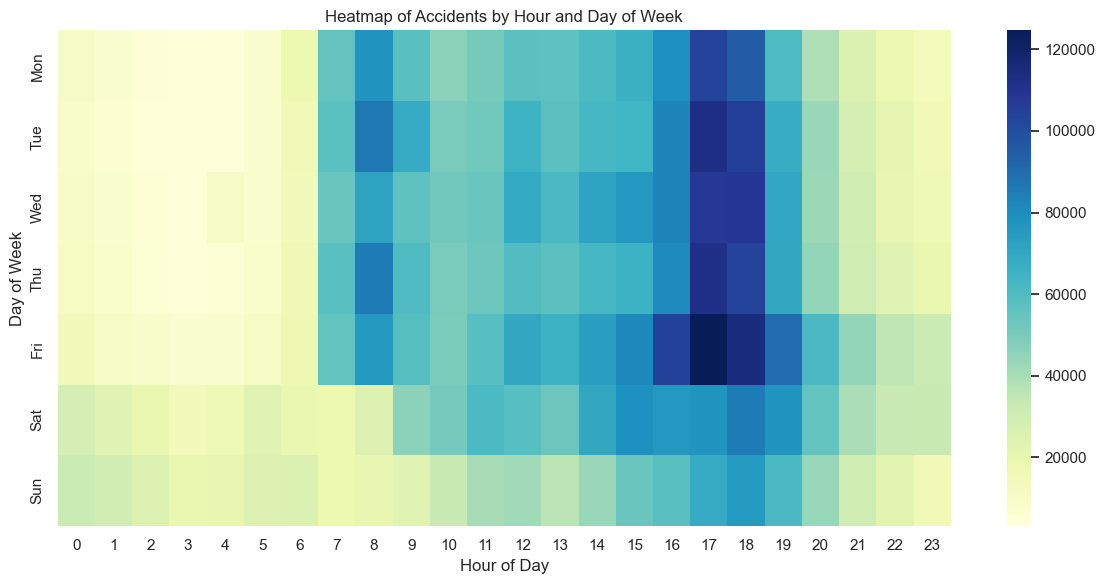

In [78]:
df_cleaned["hour"] = pd.to_numeric(df_cleaned["hour"], errors="coerce")
df_cleaned["dayofweek"] = pd.to_numeric(df_cleaned["dayofweek"], errors="coerce")

# Pivot table: rows = dayofweek, columns = hour
heatmap_data = df_cleaned.pivot_table(index="dayofweek", columns="hour", values="num_acc", aggfunc="count")

# Map dayofweek to labels (0=Monday)
heatmap_data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d")
plt.title("Heatmap of Accidents by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

There is a strong increase in accident frequency between 7 AM and 7 PM, peaking around 5–6 PM, which corresponds to typical evening rush hour traffic. Morning (6–9 AM) and especially evening peaks (4–7 PM) reflect commuting patterns. Fewest accidents happen overnight (1–5 AM)—likely due to reduced traffic volume.

The accident frequency is not uniformly distributed across hours and time of day significantly impacts accident rates.

In [73]:
from scipy.stats import chisquare

hour_counts = df_cleaned["hour"].value_counts().sort_index()
stat, p = chisquare(hour_counts)

print(f"Chi-squared statistic: {stat:.2f}, p-value: {p:.4f}")

Chi-squared statistic: 2824590.70, p-value: 0.0000


Weekdays see more accidents than weekends, especially Friday. May relate to commuting and traffic volume. There is not equal accident distribution across weekdays.

In [76]:
weekday_counts = df_cleaned["weekday_name"].value_counts().sort_index()

stat, p = chisquare(weekday_counts)

print("Chi-squared statistic:", round(stat, 2))
print("p-value:", round(p, 4))

Chi-squared statistic: 82564.14
p-value: 0.0


**Monthly Accident Trends Over Time.** 
The trend shows:
- A general **decrease** in accidents over time.
- Noticeable **seasonal fluctuations**. 
- A sharp **drop in 2020**, likely reflecting COVID-19 lockdown impacts.

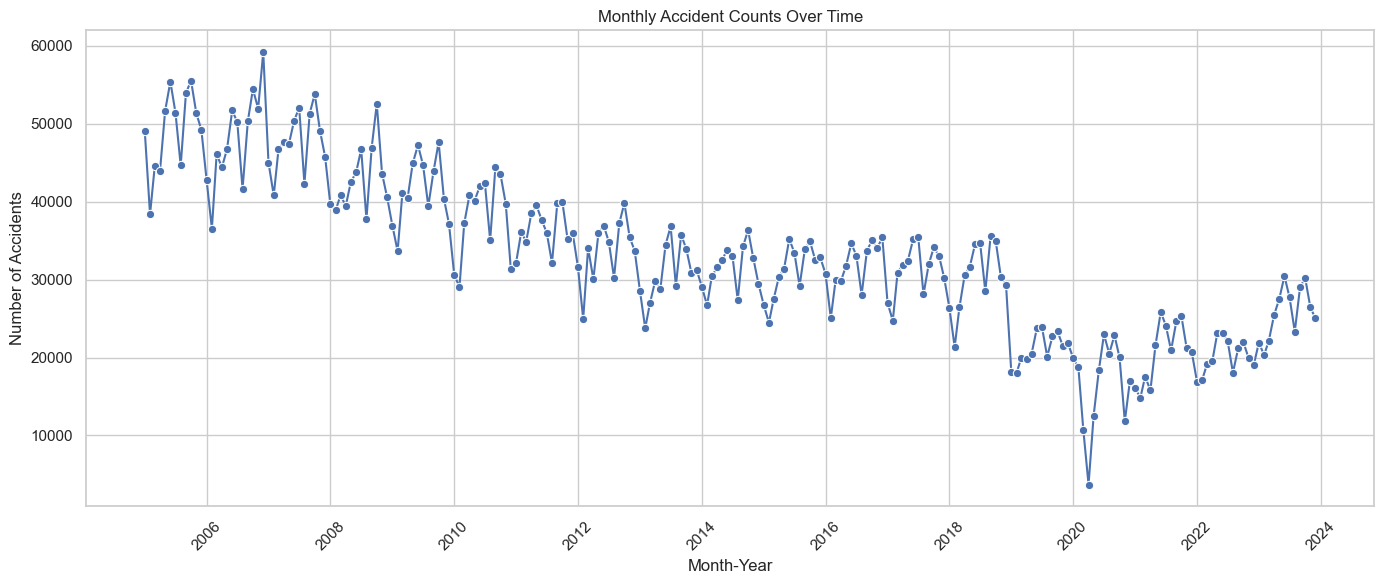

In [98]:
df_cleaned['month_year'] = pd.to_datetime(df_cleaned['datetime']).dt.to_period('M').dt.to_timestamp()

# Count accidents per month
monthly_counts = df_cleaned.groupby('month_year').size().reset_index(name='accident_count')

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts, x='month_year', y='accident_count', marker='o')
plt.title('Monthly Accident Counts Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()

#### b. Severity Distribution
As our goal is to predict the severity of road accidents, I examined the distribution of the grav variable, which represents the severity level for each user involved. The majority of entries fall under "Light injury" and "Unharmed", while "Killed" and "Hospitalized" are significantly less frequent. This imbalance indicates a class imbalance problem, which will need to be addressed during model training using techniques such as resampling or weighted loss functions.

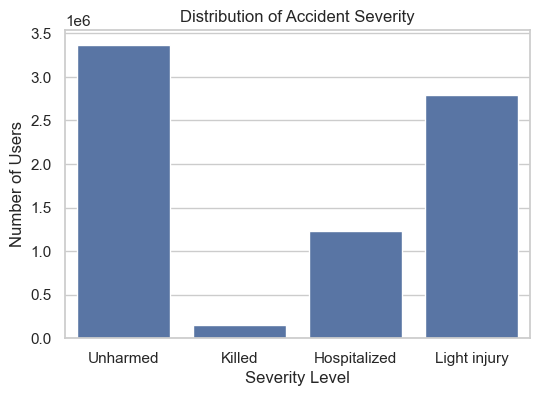

In [90]:
severity_labels = {
    1: "Unharmed", 2: "Killed", 3: "Hospitalized", 4: "Light injury"
}
df_cleaned["grav_label"] = df_cleaned["grav"].map(severity_labels)

sns.countplot(data=df_cleaned, x="grav_label", order=severity_labels.values())
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity Level")
plt.ylabel("Number of Users")
plt.show()

Check imbalance rate

In [103]:
df_cleaned["grav"].value_counts(normalize=True).mul(100).round(2).astype(str) + " %"

grav
1.0    44.66 %
4.0     37.1 %
3.0    16.29 %
2.0     1.95 %
Name: proportion, dtype: object

<Figure size 600x400 with 0 Axes>

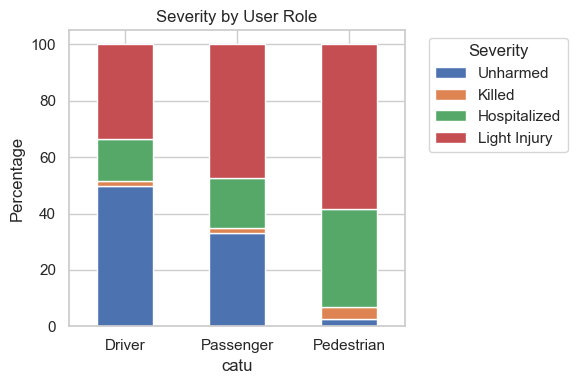

In [145]:
def plot_proportion_bar(data, group_col, title, x_labels=None):
    grouped = (
        data
        .groupby([group_col, "grav_label"], observed=True)
        .size()
        .unstack(fill_value=0)
    )

    # Convert counts to percentages
    percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Plot
    percent_df.plot(kind="bar", stacked=True)
    plt.title(title)
    plt.ylabel("Percentage")
    plt.xlabel(group_col)
    plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc='upper left')
    if x_labels:
        plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=0)
    plt.tight_layout()

# Plot: Severity by User Role
plt.figure()
plot_proportion_bar(df_cleaned, "catu", "Severity by User Role", ["Driver", "Passenger", "Pedestrian"])
plt.show()

Next I looked at **percentage distribution of injury severity** across different user roles in road accidents:

- **Drivers** have the highest proportion of unharmed outcomes.
- **Passengers** show a higher share of hospitalizations and light injuries.
- **Pedestrians** face the **greatest risk of severe outcomes**, including fatalities and hospitalizations.

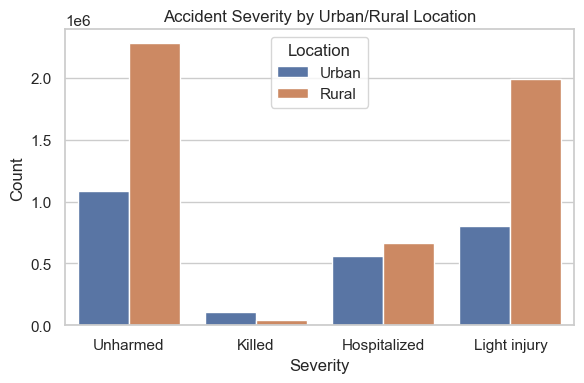

In [151]:
df_plot = df_cleaned[df_cleaned["agg"].isin([1, 2])].copy()
df_plot["agg_label"] = df_plot["agg"].map({1: "Urban", 2: "Rural"})
df_plot["grav_label"] = df_plot["grav"].map({
    1: "Unharmed", 
    2: "Killed", 
    3: "Hospitalized", 
    4: "Light injury"
})

# Plot
sns.countplot(data=df_plot, x="grav_label", hue="agg_label")
plt.title("Accident Severity by Urban/Rural Location")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.legend(title="Location")
plt.tight_layout()
plt.show()

Rural areas see more 'Light injury' and 'Unharmed' cases, possibly due to higher speeds but lower traffic density. Urban areas have slightly more fatalities, although overall fatalities are low. The number of hospitalizations is nearly equal in both zones.

This suggests that rural accidents may be more frequent but not necessarily more severe, whereas urban accidents, though fewer, may involve denser environments leading to higher severity in certain cases. This observation also corresponds to the earlier finding that pedestrians tend to experience more severe outcomes in accident incidents.

There is a statistically significant relationship between severity and accident location (urban vs rural).

In [154]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab(df_plot["grav_label"], df_plot["agg_label"])
chi2, p, _, _ = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi-square statistic: 200759.36, p-value: 0.0000


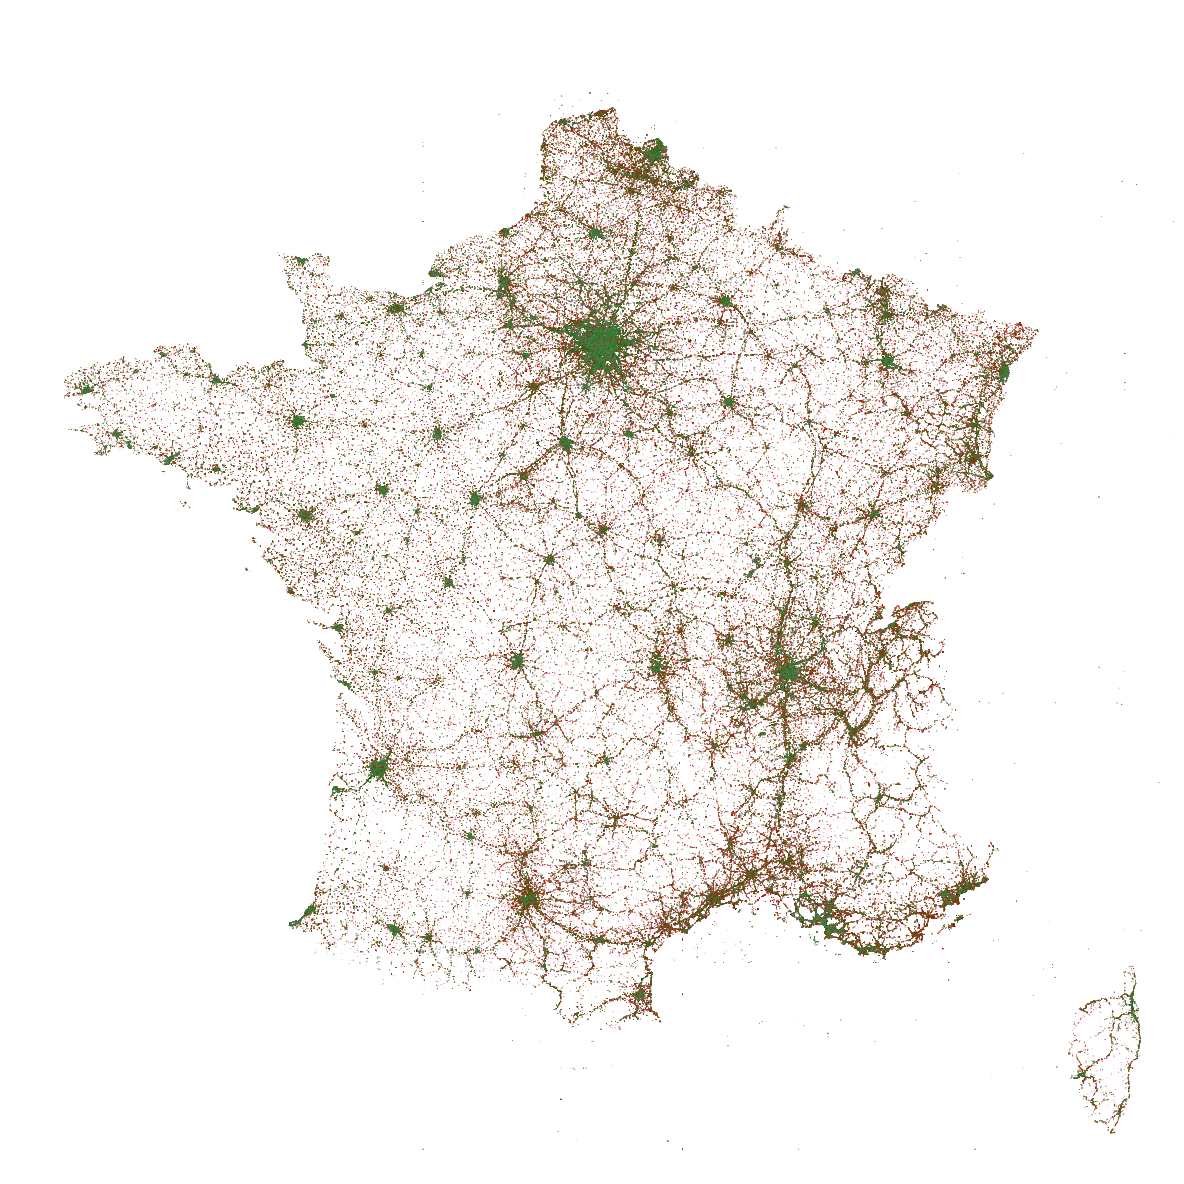

In [173]:
# Filter rows with valid latitude, longitude, and known severity
map_df = df_cleaned[
    df_cleaned["lat_clean"].notna() &
    df_cleaned["long_clean"].notna() &
    df_cleaned["grav_label"].notna()
].copy()

# Define color mapping for severity
color_map = {
    "Unharmed": "green",
    "Light injury": "orange",
    "Hospitalized": "red",
    "Killed": "purple"
}

# Ensure grav_label is treated as string to avoid Categorical fillna issue
map_df["grav_label"] = map_df["grav_label"].astype(str)
map_df["color"] = map_df["grav_label"].map(color_map).fillna("gray")

# Filter for valid GPS ranges in France
map_df = map_df[
    (map_df["lat_clean"].between(41, 52)) &
    (map_df["long_clean"].between(-5.5, 10))
]

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 12), facecolor='white')
ax.scatter(
    map_df["long_clean"], map_df["lat_clean"],
    c=map_df["color"], s=0.3, alpha=0.5, edgecolors='none'
)
ax.set_xlim(-5.5, 10)
ax.set_ylim(41, 52)
ax.axis("off")
plt.tight_layout()
plt.show()

This scatter plot visualizes the **geospatial distribution** of road accidents across France, using cleaned GPS coordinates (`lat_clean`, `long_clean`) and color-coded by injury severity:

- **Green**: Unharmed  
- **Orange**: Light injury  
- **Red**: Hospitalized  
- **Purple**: Killed  

Key observations:
- Accident hotspots cluster around major urban centers such as Paris, Lyon, Marseille, and Lille.
- Dense patterns follow road and highway networks, confirming the link between traffic infrastructure and accident frequency.

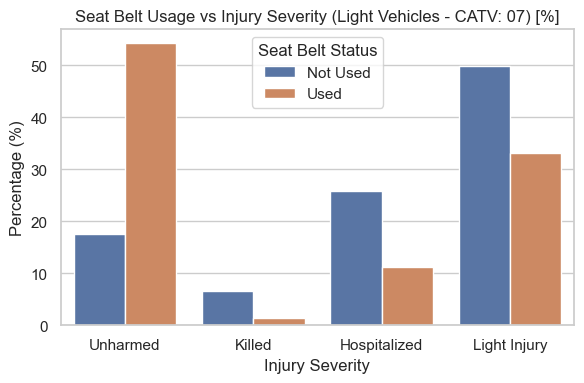

In [157]:
# Map belt status to readable labels
status_mapping = {1: "Used", 0: "Not Used"}
df_cleaned["belt_status_summary"] = df_cleaned["belt_status"].map(status_mapping)

# Filter for light vehicles (catv == 7) 
light_vehicles_df = df_cleaned[(df_cleaned["catv"] == 7)]

# Create % crosstab
belt_severity_pct = pd.crosstab(
    light_vehicles_df["belt_status_summary"],
    light_vehicles_df["grav_label"],
    normalize="index"
) * 100

# Reshape for plotting
belt_severity_melted = belt_severity_pct.reset_index().melt(
    id_vars="belt_status_summary",
    var_name="Injury Severity",
    value_name="Percentage"
)

# Plot
sns.barplot(
    data=belt_severity_melted,
    x="Injury Severity",
    y="Percentage",
    hue="belt_status_summary"
)
plt.title("Seat Belt Usage vs Injury Severity (Light Vehicles - CATV: 07) [%]")
plt.xlabel("Injury Severity")
plt.ylabel("Percentage (%)")
plt.legend(title="Seat Belt Status")
plt.tight_layout()
plt.show()


This grouped bar chart shows the relationship between **seat belt usage** and **injury severity** among users of light vehicles (`catv = 07`):

- **Users wearing seat belts** have significantly higher rates of being **unharmed** (over 50%) and much lower rates of **hospitalization** and **fatalities**.
- In contrast, **non-users** show a sharp increase in **hospitalization**, **light injuries**, and especially **fatal outcomes**.

#### c. Demographic Insights
- **Age and gender distributions** highlighted vulnerable population segments.
- Age groups were derived from `an_nais` to analyze accident involvement by demographic.

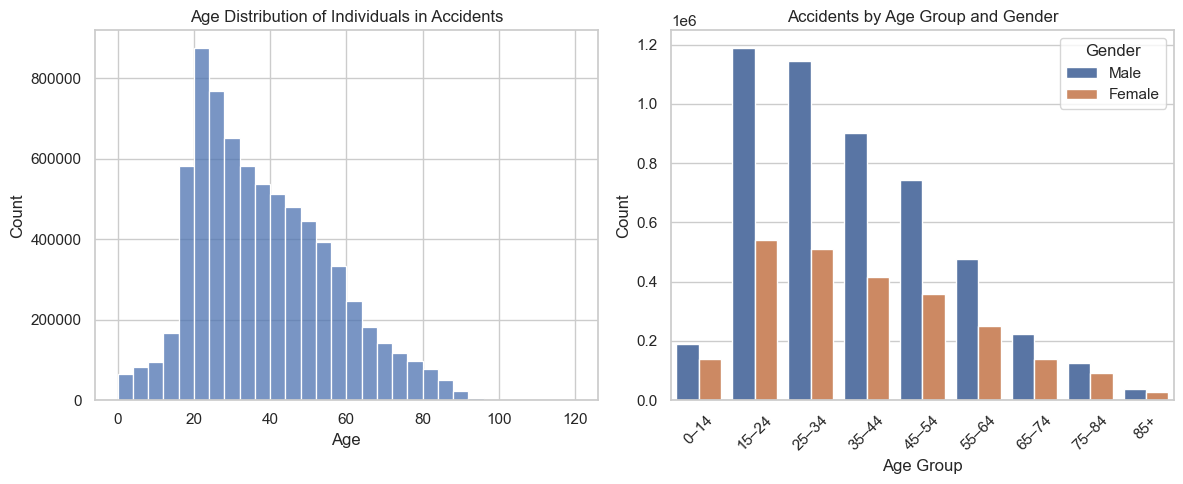

In [160]:
# Gender mapping
gender_labels = {1: "Male", 2: "Female"}
df_cleaned["gender_label"] = df_cleaned["sexe"].map(gender_labels)

# Age bins
age_bins = [0, 14, 24, 34, 44, 54, 64, 74, 84, 120]
age_labels = ["0–14", "15–24", "25–34", "35–44", "45–54", "55–64", "65–74", "75–84", "85+"]
df_cleaned["age_group"] = pd.cut(df_cleaned["age"], bins=age_bins, labels=age_labels)


# Plot 1: Age distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned["age"], bins=30, kde=False)
plt.title("Age Distribution of Individuals in Accidents")
plt.xlabel("Age")
plt.ylabel("Count")

# Plot 2: Age group by gender
plt.subplot(1, 2, 2)
sns.countplot(data=df_cleaned, x="age_group", hue="gender_label", order=age_labels)
plt.title("Accidents by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

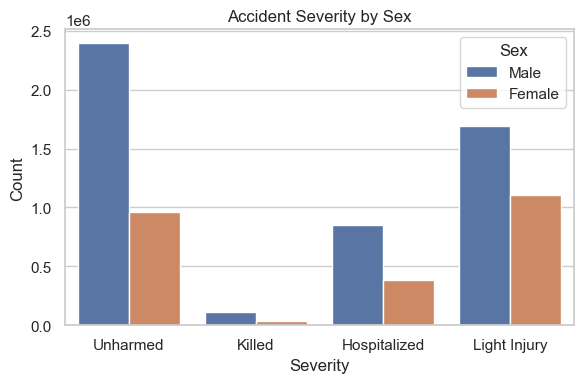

In [165]:
df_plot = df_cleaned[df_cleaned["sexe"].isin([1, 2])].copy()
df_plot["sexe_label"] = df_plot["sexe"].map({1: "Male", 2: "Female"})

# Plot
sns.countplot(data=df_plot, x="grav_label", hue="sexe_label")
plt.title("Accident Severity by Sex")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

Across all severity levels, males are involved in more accidents than females. The difference is especially noticeable in the "Unharmed" category. Notably, the number of males who were killed is also higher than females, albeit overall fatalities are low compared to other categories.

This may reflect behavioral or exposure differences, for example, men may drive more often or under riskier conditions (e.g., at night, higher speed), contributing to higher accident counts.

Statistically (Chi-square test of independence), accident severity is independent of sex

In [167]:
contingency = pd.crosstab(df_plot["grav_label"], df_plot["sexe_label"])
chi2, p, _, _ = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi-square statistic: 91552.68, p-value: 0.0000


#### d. Environmental Impact
- **Stacked plots** were used to compare severity levels across:
  - Lighting conditions (`lum`)
  - Weather conditions (`atm`)

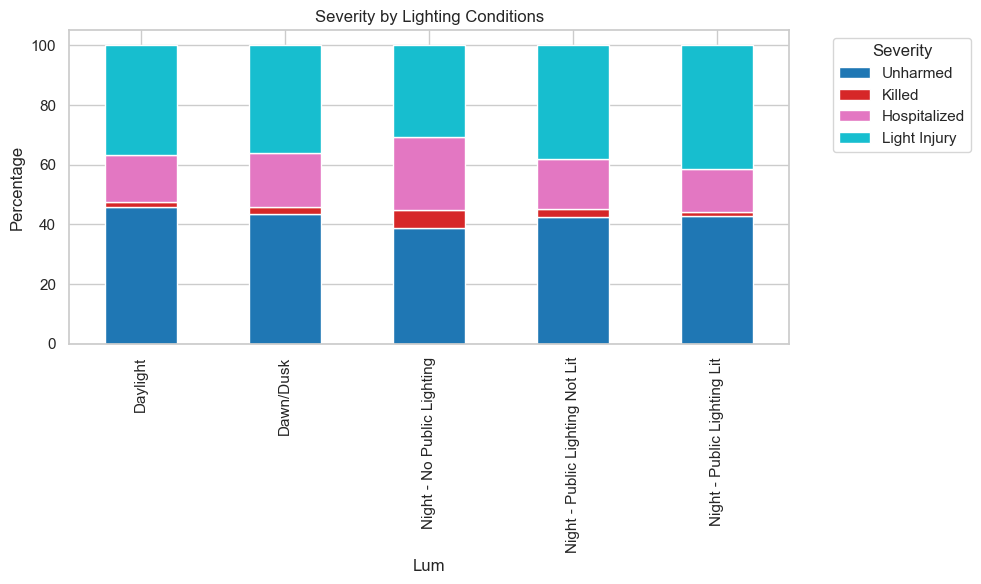

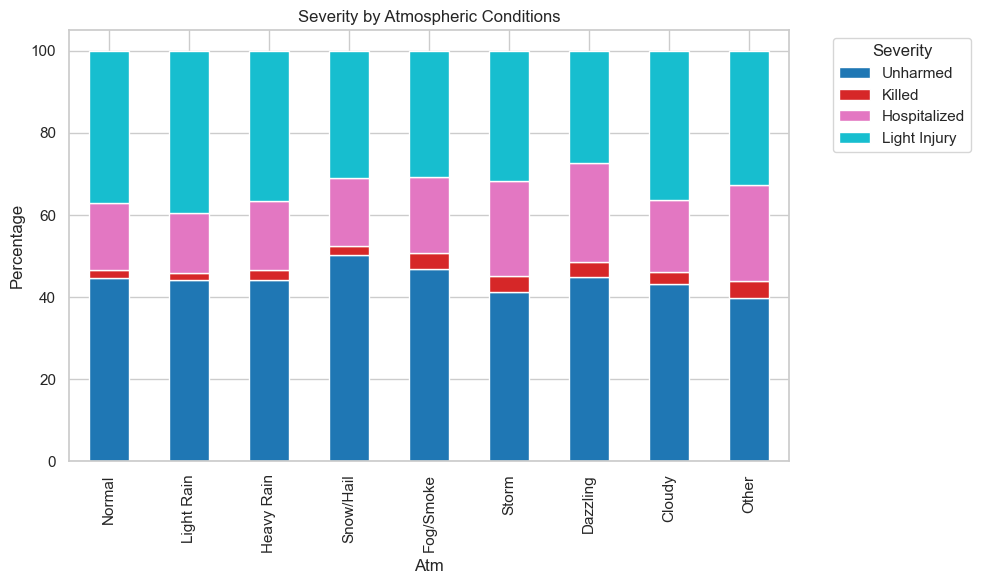

In [178]:
# Map environmental condition labels
lum_labels = {
    1: "Daylight", 2: "Dawn/Dusk", 3: "Night - No Public Lighting",
    4: "Night - Public Lighting Not Lit", 5: "Night - Public Lighting Lit"
}
atm_labels = {
    1: "Normal", 2: "Light Rain", 3: "Heavy Rain", 4: "Snow/Hail",
    5: "Fog/Smoke", 6: "Storm", 7: "Dazzling", 8: "Cloudy", 9: "Other"
}

df_cleaned["lum_label"] = df_cleaned["lum"].map(lum_labels)
df_cleaned["atm_label"] = df_cleaned["atm"].map(atm_labels)

# Plot function for stacked % bars
def plot_severity_stacked(data, category_col, title):
    counts = data.groupby([category_col, "grav_label"], observed=True).size().unstack(fill_value=0)
    percent = counts.div(counts.sum(axis=1), axis=0) * 100
    percent.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab10")
    plt.title(title)
    plt.ylabel("Percentage")
    plt.xlabel(category_col.replace("_label", "").capitalize())
    plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 1. Severity by Lighting
plot_severity_stacked(df_cleaned[df_cleaned["lum_label"].notna()], "lum_label", "Severity by Lighting Conditions")

# 2. Severity by Weather
plot_severity_stacked(df_cleaned[df_cleaned["atm_label"].notna()], "atm_label", "Severity by Atmospheric Conditions")